In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
import umap
import scipy.sparse as sparse
from scipy.io import mmwrite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import anndata as ad

In [19]:
def pickle_reader(path):
    emb_input = pd.read_pickle(path)
    return emb_input

def reformat_pickle(emb_input):
    """Change every dash (-) by underscore to allow datasets merging"""
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v
    return reformatted_emb

def reformat_df(ORF2_counts):
    """Change every dash (-) and dot (.) by underscore (_) to allow datasets merging"""
    reformatted_counts_dict = {}
    counts = ORF2_counts['Non_redundant']
    names = ORF2_counts['ID']
    for i in range(len(ORF2_counts)):
        number = counts[i]
        ID = names[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        #print(clean)
        reformatted_counts_dict[clean] = number
        #reformatted_counts_dict
    
    reformatted = pd.DataFrame.from_dict(reformatted_counts_dict, orient='index')
    reformatted_counts = reformatted.reset_index()
    reformatted_counts.columns = ['ID', 'Non_redundant']
    return reformatted_counts
    
def pickle_to_matrix(reformatted_emb):    # Reading pickle file containing embeddings
    matrix_inverted = pd.DataFrame(reformatted_emb)  # Create df from emb dict
    matrix = matrix_inverted.transpose()  # Invert rows and columns to make it fit for Anndata object
    #matrix.index = ["dimension" + str(i) for i in range(1, matrix.shape[0]+1)]  # dimension as rows, each entry as a column
    return matrix 

def match_ID(matrix, reformatted_counts):
    """Matching matrix (embs) and IDs from counts file to use embs observations with counts associated (all)"""
   #matched_IDs = matrix.loc[:, matrix.index.isin(reformatted_counts["ID"].values)]
    matched_emb = matrix.loc[matrix.index.isin(reformatted_counts['ID'].values)]
    matched_counts = reformatted_counts.loc[reformatted_counts['ID'].isin(matrix.index)] 
    return matched_emb, matched_counts

def AnnData_Object(matched_emb):
    """ anndata is a Python package for handling annotated data matrices in memory and on disk, 
        positioned between pandas and xarray"""
    #adata = ad.AnnData(X=matched_IDs.index, obs=pd.DataFrame(index=matched_IDs.columns))
    adata = ad.AnnData(X = matched_emb.values, obs = matched_emb.index.to_list(),var = matched_emb.columns.tolist())
    return adata

def add_counts(adata, matched_counts):
    """Including counts information in emb matrix"""
    ID_embeddings = pd.DataFrame(matched_emb.index)
    ID_embeddings.columns = ["ID"]
    ID_embeddings_with_counts = pd.merge(ID_embeddings, matched_counts)
    ID_embeddings_with_counts.columns = ['ID', 'Non_redundant']
    #assert all(ID_embeddings.index == ID_embeddings_with_counts["ID"])
    #adata.obs["ORF_all_counts"] = ID_embeddings_with_counts["All"].values
    adata.obs["Non_redundant"] = pd.Categorical(ID_embeddings_with_counts["Non_redundant"].values)
    #return adata   # no need to return a variable, just modify adata object

def color_code(adata):
    # Set up color gradient for labels (labels are stored in a column called "Non_redundant")
    label_colors = np.linspace(0, 1, len(np.unique(adata.obs["Non_redundant"])))
    label_cmap = plt.cm.get_cmap("rainbow")
    label_color_dict = dict(zip(np.unique(adata.obs["Non_redundant"]), label_cmap(label_colors)))    
    return label_cmap, label_color_dict
    
def run_pca(adata, label_color_dict):
    """Define a function to run PCA and visualize"""
    # Scale data (do it only once)
    sc.pp.scale(adata)
    # Run PCA
    sc.tl.pca(adata, svd_solver='arpack')
   
    # Define graph format and color code 
    fig, ax = plt.subplots(figsize=(6, 6))  
    sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=label_cmap)
    sm.set_array([])
    
    # Generate PCA
    sc.pl.pca(adata, annotate_var_explained=True, color="Non_redundant", size=75, 
              ax=ax, show=False, palette=label_color_dict, legend_loc=None)   # palette=label_color_dict to color dots // save = True
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
    cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
    plt.show()

def run_umap(adata, label_color_dict):
    """Select PCs and plot UMAP"""
    # Run before to select PCs UMAP
    #sc.tl.pca(data, n_comps=21)
    #sc.pl.pca_variance_ratio(data, log=True)
    
    # Define graph format and color code 
    fig, ax = plt.subplots(figsize=(6, 6))  
    sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=label_cmap)
    sm.set_array([])
    # Generates UMAP
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=7)
    sc.tl.umap(adata)
    # Visualize UMAP results
    sc.pl.umap(adata, color='Non_redundant', size=75, 
                ax=ax, show=False, palette=label_color_dict, legend_loc=None) # legend_loc=None: Do not show all dots in the legend
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04)    # modify color bar size and position
    cbar.ax.set_ylabel("Non_redundant_counts", rotation=270, labelpad=15)  # set label legend
    plt.show()

In [20]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path = '/Users/leandro/Desktop/ai_data/data/embeddings_v2.pickle'
emb_input = pickle_reader(path)
reformatted_emb = reformat_pickle(emb_input)
#reformatted_emb

In [21]:
# -- Read ORF2_counts file and reformat to remove dash and dots by underscore
path_counts = '/Users/leandro/Desktop/ai_data/data/ORF2p_counts.csv'
ORF2_counts = pd.read_csv(path_counts)
reformatted_counts = reformat_df(ORF2_counts)
#reformatted_counts

In [22]:
# -- Creating matrix from reformatted_emb dict and filtering counts and emb dataset to same length
matrix = pickle_to_matrix(reformatted_emb)
#matrix
matched_emb = match_ID(matrix, reformatted_counts)[0]
#matches_emb
matched_counts = match_ID(matrix, reformatted_counts)[1]
#matched_counts

In [23]:
print(len(matrix.index), len(matched_emb.index), len(matched_counts.index))  # Test number of matchs between datasets

721 720 720


In [24]:
# -- Create AnnData and including count information
adata = AnnData_Object(matched_emb)
#adata.obs
add_counts(adata, matched_counts)
#adata.shape
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 720 × 1024
    obs: 0, 'Non_redundant'
    var: 0>

In [25]:
label_cmap = color_code(adata)[0]
label_color_dict = color_code(adata)[1]

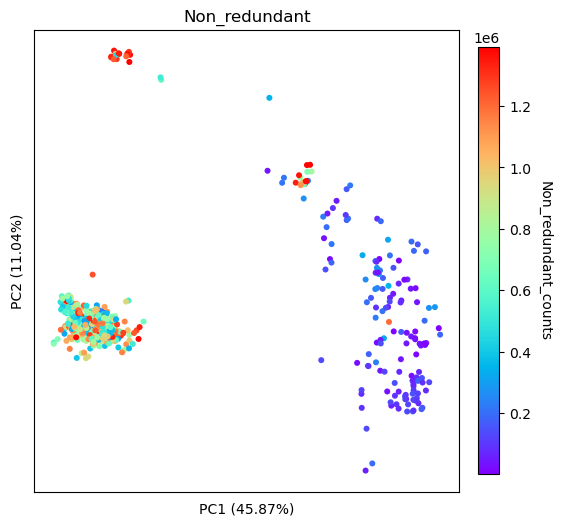

In [26]:
run_pca(adata, label_color_dict)

In [27]:
adata.uns['pca']['variance_ratio']  # Ratio of explained variance for each one of the 50 PCs

array([0.4586967 , 0.11044925, 0.09241765, 0.05348343, 0.03966725,
       0.03861615, 0.02720741, 0.02089981, 0.01748342, 0.01564231,
       0.01181163, 0.01063831, 0.00799136, 0.00723257, 0.00605841,
       0.00593636, 0.00532668, 0.00470236, 0.00428955, 0.0037866 ,
       0.00336081, 0.00262501, 0.00248848, 0.0023594 , 0.00202306,
       0.00185418, 0.00179208, 0.00169489, 0.00164795, 0.00139663,
       0.00132496, 0.0012297 , 0.00116444, 0.00110313, 0.00102051,
       0.00095179, 0.00091109, 0.00088994, 0.00084304, 0.00079006,
       0.00076962, 0.00073603, 0.00070491, 0.00066668, 0.00066415,
       0.00060358, 0.00058207, 0.00057374, 0.00054573, 0.00051586],
      dtype=float32)

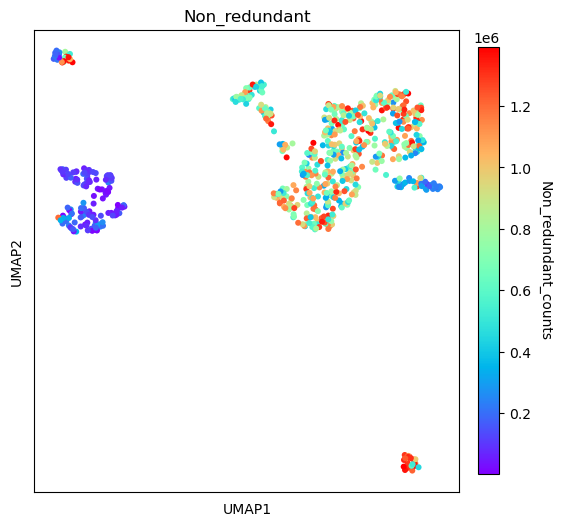

In [28]:
run_umap(adata, label_color_dict)